# WATER BAG EVENT CATALOG - PREPROCESSING & FEATURE ENGINEERING

### Planning

Model arquitecture options:
1. Binary labels for (any) incident ocorrence in time intervals - Done
1. Binary labels for incident ocorrence in time intervals for each incident group - Done
1. Labels for each incident group (+ no incident) in time intervals
4. Shift labels to predict future ocorrence per hours prior
    1. Shift labels one, two, three positions to predict risk for next one, two, three hours (separate model for each hour step).
6. Reorder columns values as first, second ... stations closer
7. Predict incident quantity per day, week and month, in city, neighborhoods and clusters.
8. Predict time until next event (for city and event groups)

Feature Engineering:
1. Time serie index (Make it a time serie model)
1. Trimester, month, week, day of the year.
2. Acumulated on last one, two, three... records (hours).

Obs: Filter records by arbitrary rule to reduce samples and overcome imbalancement

#### Import modules and libraries

In [1]:
import os, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Water bag groupped events collection

In [2]:
waterbags = pd.read_csv('../Dados/Catalog/water_bag_catalog_google.csv', index_col=0)
clusters = pd.read_csv('../Dados/Clusters/clusters_bolsões_micro.csv', index_col=0)

display(waterbags.head(4)); display(clusters.shape)

,EVENTO_TITULO,EVENTO_DESCRICAO,POP_TITULO,EVENTO_PRAZO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,EVENTO_LATITUDE,EVENTO_LONGITUDE,EVENTO_INICIO,EVENTO_FIM,...,types,location_type,neighborhood,route,street_number,postal_code,formatted_address,premise,search_lat,search_lng
EVENTO_ID,,,,,,,,,,,,,,,,,,,,,
1258,Bolsão d'agua,R. Pinheiro Machado com Muniz Barreto - Botafogo,Bolsão d'água em via,NaN,BAIXO,NaN,-22.944774,-43.183917,2015-09-12 20:12:00,2015-09-13 03:39:00,...,['street_address'],ROOFTOP,Botafogo,Rua Muniz Barreto,366,22251-090,"R. Muniz Barreto, 366 - Botafogo, Rio de Janei...",NaN,-22.944790,-43.184068
1259,Bolsão,"Av. Novo Rio, 3131 - Bonsucesso",Bolsão d'água em via,NaN,BAIXO,NaN,-22.871684,-43.256200,2015-09-12 22:13:00,2015-09-13 01:21:00,...,['premise'],ROOFTOP,Bonsucesso,Avenida Novo Rio,3131,21051-051,"Av. Novo Rio, 3131 - Bonsucesso, Rio de Janeir...",NaN,-22.871948,-43.256108
1260,Bolsão,"Av. Ataulfo de Paiva, 752 - Leblon",Bolsão d'água em via,NaN,BAIXO,NaN,-22.984337,-43.223100,2015-09-12 22:15:00,2015-09-13 01:20:00,...,['street_address'],ROOFTOP,Leblon,Avenida Ataulfo de Paiva,750,22440-033,"Av. Ataulfo de Paiva, 750 - Leblon, Rio de Jan...",NaN,-22.984207,-43.223015
1261,Bolsão,Avenida General San Martin / Praça Antero de Q...,Bolsão d'água em via,NaN,BAIXO,NaN,-22.984337,-43.223100,2015-09-12 22:16:00,2015-09-13 01:20:00,...,['street_address'],ROOFTOP,Leblon,Avenida Ataulfo de Paiva,750,22440-033,"Av. Ataulfo de Paiva, 750 - Leblon, Rio de Jan...",NaN,-22.984207,-43.223015


(3140, 20)

---
# 1. Stations' records labeled by water bag event ocorrence

### Transform functions

In [3]:
def intervals_intersect_interval(values_min, values_max, time_min, time_max):
    return ~((values_max <= time_min) | (values_min >= time_max))

def timeSequenceEventLabels(time_serie, target, start, end, groups, report=1000): # Accepts time_serie as pandas Datetime Index
    
    period_label = []
    for i in range(time_serie.shape[0] - 1):
        if (i+1) % report == 0:
            co(wait=True); print(f'{i+1}/{time_serie.shape[0] - 1} bin edges evaluated...')
        periods_intersect = intervals_intersect_interval(target[start], target[end], time_serie[i], time_serie[i+1])
        target_bin = target[periods_intersect]
        label = 1 if len(target_bin) else 0
        n_events = len(target_bin)
        event_ids = target_bin.index.tolist()
        event_groups = target_bin[groups].tolist()
        period_label.append([label, n_events, event_ids, event_groups])
    print(f'Done! {time_serie.shape[0] - 1} periods evaluated.')
    return pd.DataFrame(period_label, columns=['label', 'events', 'event ids', 'event groups'], index=time_serie[:-1])

### Water bag events

#### Join clusters data to water bag events collection

In [4]:
events = waterbags[['EVENTO_INICIO', 'EVENTO_FIM']].apply(pd.to_datetime)
events = events.join(clusters['sublabel'], how='inner')

display(events.head(4), events.shape)

,EVENTO_INICIO,EVENTO_FIM,sublabel
EVENTO_ID,,,
1258,2015-09-12 20:12:00,2015-09-13 03:39:00,9
1259,2015-09-12 22:13:00,2015-09-13 01:21:00,-1
1260,2015-09-12 22:15:00,2015-09-13 01:20:00,-1
1261,2015-09-12 22:16:00,2015-09-13 01:20:00,-1


(3140, 3)

### Base temporal serie to label by event ocorrence

#### 2015-06-01 à 2022-06-01

In [9]:
base_timeserie = pd.date_range('2015-06-01', '2022-06-01', freq='15Min')

### Label time records by water bag event ocorrence

In [10]:
event_ts = timeSequenceEventLabels(
    base_timeserie, events,
    start='EVENTO_INICIO',
    end='EVENTO_FIM',
    groups='sublabel',
    report=1000,
)

245000/245472 bin edges evaluated...
Done! 245472 periods evaluated.


#### Save labeled time serie

In [58]:
event_ts.to_csv('../Dados/Transform/série_bolsões.csv', index=True)

#### Reload & preprocess

In [5]:
event_ts = pd.read_csv('../Dados/Transform/série_bolsões.csv', index_col=0)

# Convert columns contaning lists from string to json objects
event_ts['event groups'] = event_ts['event groups'].map(json.loads)
event_ts['event ids'] = event_ts['event ids'].map(json.loads)

# Convert index to datetime
event_ts.set_index(pd.to_datetime(event_ts.index), inplace=True)

display(event_ts.sample(5), event_ts.shape)

,label,events,event ids,event groups
2021-01-26 11:00:00,0,0,[],[]
2018-03-16 15:15:00,0,0,[],[]
2018-04-12 21:15:00,0,0,[],[]
2020-08-05 08:30:00,0,0,[],[]
2015-08-12 09:15:00,0,0,[],[]


(245472, 4)

---
# 3. Stations' records labeled per cluster group

### Time serie of event ocorrence per group

In [65]:
groups = np.unique(event_ts['event groups'].sum())
groups_labels = [event_ts['event groups'].rename(group).map(lambda labels: int((group in labels))) for group in groups]
group_ts = pd.concat(groups_labels, 1)

group_ts.shape

(245472, 80)

#### Save time serie labeled per group

In [135]:
# group_ts.to_csv('../Dados/Transform/série_bolsões_clusters.csv', index=True)

#### Reload & preprocess

In [6]:
# Reload
group_ts = pd.read_csv('../Dados/Transform/série_bolsões_clusters.csv', index_col=0)
group_ts.set_index(pd.to_datetime(group_ts.index), inplace=True)

display(group_ts.sample(5), group_ts.shape)

,-1,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,81,82
2019-02-05 21:15:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-02 10:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-02-17 12:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-03 15:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-25 22:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(245472, 80)

---
# Result Visualization

### Event time count

In [7]:
event_ts['label'].value_counts(normalize=True)#.round(4) * 100

0    0.910845
1    0.089155
Name: label, dtype: float64

#### Obs: 8,9 % of time records are positive for water bag events in the city

### Event frequency

<ipython-input-14-7e15ba7e487f>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set(xlim=(pd.datetime(2021, 6, 1), pd.datetime(2022, 10, 1)))


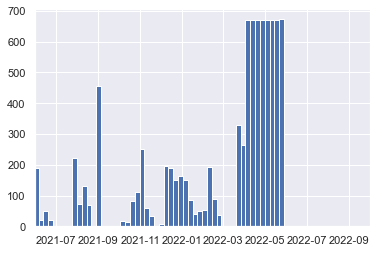

In [14]:
event_stamps = event_ts[event_ts['label']==1].index
time_bins = pd.date_range('2015-06', '2022-06', freq='W')
ax = plt.figure().add_subplot()
ax.hist(event_stamps, bins=time_bins)
ax.set(xlim=(pd.datetime(2021, 6, 1), pd.datetime(2022, 10, 1)))
plt.show()

---
# Time Features

In [90]:
ts = event_ts.index

ts_eng = event_ts[[]].copy()

keys = [
    'year', 'month', 'day', 'hour', 'minute', 'date', 'time',
    'index', 'dayofyear', 'weekofyear', 'weekday', 'quarter'
]

values = [
    ts.year, ts.month, ts.day, ts.hour, ts.minute, ts.date, ts.time,
    range(ts.shape[0]), ts.dayofyear, ts.weekofyear, ts.weekday, ts.quarter
]

ts_eng = pd.DataFrame(np.array(values).T, index=ts, columns=keys)

### Save time features

In [96]:
ts_eng.to_csv('../Dados/Feature Engineering/tim_features.csv', index=True)

### Reload

In [97]:
ts_eng = pd.read_csv('../Dados/Feature Engineering/tim_features.csv', index_col=0)

display(ts_eng.head(), ts_eng.shape)

,year,month,day,hour,minute,date,time,index,dayofyear,weekofyear,weekday,quarter
2015-06-01 00:00:00,2015,6,1,0,0,2015-06-01,00:00:00,0,152,23,0,2
2015-06-01 00:15:00,2015,6,1,0,15,2015-06-01,00:15:00,1,152,23,0,2
2015-06-01 00:30:00,2015,6,1,0,30,2015-06-01,00:30:00,2,152,23,0,2
2015-06-01 00:45:00,2015,6,1,0,45,2015-06-01,00:45:00,3,152,23,0,2
2015-06-01 01:00:00,2015,6,1,1,0,2015-06-01,01:00:00,4,152,23,0,2


(245472, 12)